In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # MC方法生成多个episode，每个episode中更新Q和policy
    for i_episode in range(1, num_episodes+1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end='')
            sys.stdout.flush()
        
        # 使用当前policy,生成mento-carlo样本
        state = env.reset()
        series = [] # (state, action, reward)样本
        while True: # 在风墙的例子中，采样过程太过缓慢
            print(stats.episode_lengths[i_episode-1])
            action_probs = policy(state)  # 此处动态引用Q，policy会随Q变化
            action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
            next_state, reward, done, _ = env.step(action)
            series.append((state, action, reward))
            
            # 更新统计状态
            stats.episode_lengths[i_episode-1] += 1
            stats.episode_rewards[i_episode-1] += reward
            if stats.episode_lengths[i_episode-1] + 1 % 100 == 0:
                print("\r Episode {}, Steps {}, Rewards {}".format(i_episode, 
                                                                   stats.episode_lengths[i_episode-1], 
                                                                   stats.episode_rewards[i_episode-1]),
                      end="")
                sys.stdout.flush()
            
            if done:
                break
                
            state = next_state 

        state_action_set = set([(state, action) for state, action, _ in series])
        for state, action in state_action_set:
            # 找到state, action第一次出现
            first_index = next(i for i, (state_i, action_i, _) in enumerate(series) \
                               if state_i == state and action_i == action)
            # 计算奖励
            G = sum([reward*(discount_factor**i) \
                     for i, (_,_, reward) in enumerate(series[first_index:])])
            
            # 更新状态行为函数
            returns_sum[(state,action)] += G
            returns_count[(state,action)] += 1
            Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]
        
        # 根据Q，更新当前policy
        # policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        # 无需更新policy，它由Q表完全决定行为
    
    return Q, stats

In [5]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end = '')
            sys.stdout.flush()
        
        # 使用当前policy，生成样本
        state = env.reset()
        action = np.random.choice(np.arange(env.nA), p=policy(state))
        while True:
            next_state, reward, done, _ = env.step(action)
            next_action = np.random.choice(np.arange(env.nA), p=policy(next_state))
            
            # 更新Q,由于policy有Q的引用，所以也就隐式的更新了
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            # 更新算法状态
            state = next_state
            action = next_action
            
            # 更新统计状态
            stats.episode_lengths[i_episode] += 1
            stats.episode_rewards[i_episode] += reward
            
            if done:
                break
    
    return Q, stats

In [6]:
Q, stats = sarsa(env, 200)

Episode 200/200.

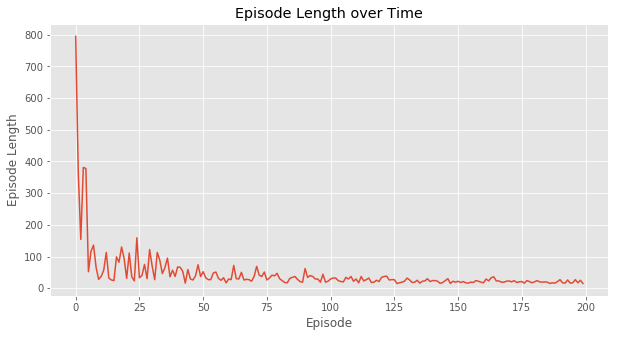

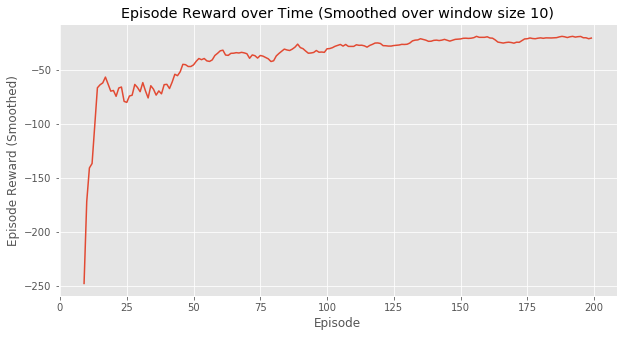

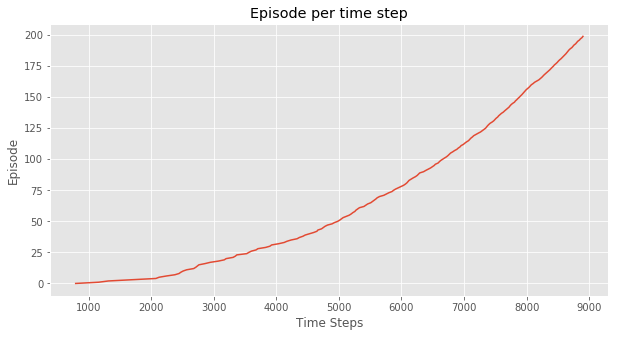

(<matplotlib.figure.Figure at 0x9ffeac8>,
 <matplotlib.figure.Figure at 0xa42fe48>)

In [7]:
plotting.plot_episode_stats(stats)

In [8]:
Q, stats = mc_control_epsilon_greedy(env, 200) # 可以尝试执行此代码，会等待很长时间，收敛太慢。

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


1448.0
1449.0
1450.0
1451.0
1452.0
1453.0
1454.0
1455.0
1456.0
1457.0
1458.0
1459.0
1460.0
1461.0
1462.0
1463.0
1464.0
1465.0
1466.0
1467.0
1468.0
1469.0
1470.0
1471.0
1472.0
1473.0
1474.0
1475.0
1476.0
1477.0
1478.0
1479.0
1480.0
1481.0
1482.0
1483.0
1484.0
1485.0
1486.0
1487.0
1488.0
1489.0
1490.0
1491.0
1492.0
1493.0
1494.0
1495.0
1496.0
1497.0
1498.0
1499.0
1500.0
1501.0
1502.0
1503.0
1504.0
1505.0
1506.0
1507.0
1508.0
1509.0
1510.0
1511.0
1512.0
1513.0
1514.0
1515.0
1516.0
1517.0
1518.0
1519.0
1520.0
1521.0
1522.0
1523.0
1524.0
1525.0
1526.0
1527.0
1528.0
1529.0
1530.0
1531.0
1532.0
1533.0
1534.0
1535.0
1536.0
1537.0
1538.0
1539.0
1540.0
1541.0
1542.0
1543.0
1544.0
1545.0
1546.0
1547.0
1548.0
1549.0
1550.0
1551.0
1552.0
1553.0
1554.0
1555.0
1556.0
1557.0
1558.0
1559.0
1560.0
1561.0
1562.0
1563.0
1564.0
1565.0
1566.0
1567.0
1568.0
1569.0
1570.0
1571.0
1572.0
1573.0
1574.0
1575.0
1576.0
1577.0
1578.0
1579.0
1580.0
1581.0
1582.0
1583.0
1584.0
1585.0
1586.0
1587.0
1588.0
1589.0
1590.0

2942.0
2943.0
2944.0
2945.0
2946.0
2947.0
2948.0
2949.0
2950.0
2951.0
2952.0
2953.0
2954.0
2955.0
2956.0
2957.0
2958.0
2959.0
2960.0
2961.0
2962.0
2963.0
2964.0
2965.0
2966.0
2967.0
2968.0
2969.0
2970.0
2971.0
2972.0
2973.0
2974.0
2975.0
2976.0
2977.0
2978.0
2979.0
2980.0
2981.0
2982.0
2983.0
2984.0
2985.0
2986.0
2987.0
2988.0
2989.0
2990.0
2991.0
2992.0
2993.0
2994.0
2995.0
2996.0
2997.0
2998.0
2999.0
3000.0
3001.0
3002.0
3003.0
3004.0
3005.0
3006.0
3007.0
3008.0
3009.0
3010.0
3011.0
3012.0
3013.0
3014.0
3015.0
3016.0
3017.0
3018.0
3019.0
3020.0
3021.0
3022.0
3023.0
3024.0
3025.0
3026.0
3027.0
3028.0
3029.0
3030.0
3031.0
3032.0
3033.0
3034.0
3035.0
3036.0
3037.0
3038.0
3039.0
3040.0
3041.0
3042.0
3043.0
3044.0
3045.0
3046.0
3047.0
3048.0
3049.0
3050.0
3051.0
3052.0
3053.0
3054.0
3055.0
3056.0
3057.0
3058.0
3059.0
3060.0
3061.0
3062.0
3063.0
3064.0
3065.0
3066.0
3067.0
3068.0
3069.0
3070.0
3071.0
3072.0
3073.0
3074.0
3075.0
3076.0
3077.0
3078.0
3079.0
3080.0
3081.0
3082.0
3083.0
3084.0

4148.0
4149.0
4150.0
4151.0
4152.0
4153.0
4154.0
4155.0
4156.0
4157.0
4158.0
4159.0
4160.0
4161.0
4162.0
4163.0
4164.0
4165.0
4166.0
4167.0
4168.0
4169.0
4170.0
4171.0
4172.0
4173.0
4174.0
4175.0
4176.0
4177.0
4178.0
4179.0
4180.0
4181.0
4182.0
4183.0
4184.0
4185.0
4186.0
4187.0
4188.0
4189.0
4190.0
4191.0
4192.0
4193.0
4194.0
4195.0
4196.0
4197.0
4198.0
4199.0
4200.0
4201.0
4202.0
4203.0
4204.0
4205.0
4206.0
4207.0
4208.0
4209.0
4210.0
4211.0
4212.0
4213.0
4214.0
4215.0
4216.0
4217.0
4218.0
4219.0
4220.0
4221.0
4222.0
4223.0
4224.0
4225.0
4226.0
4227.0
4228.0
4229.0
4230.0
4231.0
4232.0
4233.0
4234.0
4235.0
4236.0
4237.0
4238.0
4239.0
4240.0
4241.0
4242.0
4243.0
4244.0
4245.0
4246.0
4247.0
4248.0
4249.0
4250.0
4251.0
4252.0
4253.0
4254.0
4255.0
4256.0
4257.0
4258.0
4259.0
4260.0
4261.0
4262.0
4263.0
4264.0
4265.0
4266.0
4267.0
4268.0
4269.0
4270.0
4271.0
4272.0
4273.0
4274.0
4275.0
4276.0
4277.0
4278.0
4279.0
4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4286.0
4287.0
4288.0
4289.0
4290.0

5448.0
5449.0
5450.0
5451.0
5452.0
5453.0
5454.0
5455.0
5456.0
5457.0
5458.0
5459.0
5460.0
5461.0
5462.0
5463.0
5464.0
5465.0
5466.0
5467.0
5468.0
5469.0
5470.0
5471.0
5472.0
5473.0
5474.0
5475.0
5476.0
5477.0
5478.0
5479.0
5480.0
5481.0
5482.0
5483.0
5484.0
5485.0
5486.0
5487.0
5488.0
5489.0
5490.0
5491.0
5492.0
5493.0
5494.0
5495.0
5496.0
5497.0
5498.0
5499.0
5500.0
5501.0
5502.0
5503.0
5504.0
5505.0
5506.0
5507.0
5508.0
5509.0
5510.0
5511.0
5512.0
5513.0
5514.0
5515.0
5516.0
5517.0
5518.0
5519.0
5520.0
5521.0
5522.0
5523.0
5524.0
5525.0
5526.0
5527.0
5528.0
5529.0
5530.0
5531.0
5532.0
5533.0
5534.0
5535.0
5536.0
5537.0
5538.0
5539.0
5540.0
5541.0
5542.0
5543.0
5544.0
5545.0
5546.0
5547.0
5548.0
5549.0
5550.0
5551.0
5552.0
5553.0
5554.0
5555.0
5556.0
5557.0
5558.0
5559.0
5560.0
5561.0
5562.0
5563.0
5564.0
5565.0
5566.0
5567.0
5568.0
5569.0
5570.0
5571.0
5572.0
5573.0
5574.0
5575.0
5576.0
5577.0
5578.0
5579.0
5580.0
5581.0
5582.0
5583.0
5584.0
5585.0
5586.0
5587.0
5588.0
5589.0
5590.0

6936.0
6937.0
6938.0
6939.0
6940.0
6941.0
6942.0
6943.0
6944.0
6945.0
6946.0
6947.0
6948.0
6949.0
6950.0
6951.0
6952.0
6953.0
6954.0
6955.0
6956.0
6957.0
6958.0
6959.0
6960.0
6961.0
6962.0
6963.0
6964.0
6965.0
6966.0
6967.0
6968.0
6969.0
6970.0
6971.0
6972.0
6973.0
6974.0
6975.0
6976.0
6977.0
6978.0
6979.0
6980.0
6981.0
6982.0
6983.0
6984.0
6985.0
6986.0
6987.0
6988.0
6989.0
6990.0
6991.0
6992.0
6993.0
6994.0
6995.0
6996.0
6997.0
6998.0
6999.0
7000.0
7001.0
7002.0
7003.0
7004.0
7005.0
7006.0
7007.0
7008.0
7009.0
7010.0
7011.0
7012.0
7013.0
7014.0
7015.0
7016.0
7017.0
7018.0
7019.0
7020.0
7021.0
7022.0
7023.0
7024.0
7025.0
7026.0
7027.0
7028.0
7029.0
7030.0
7031.0
7032.0
7033.0
7034.0
7035.0
7036.0
7037.0
7038.0
7039.0
7040.0
7041.0
7042.0
7043.0
7044.0
7045.0
7046.0
7047.0
7048.0
7049.0
7050.0
7051.0
7052.0
7053.0
7054.0
7055.0
7056.0
7057.0
7058.0
7059.0
7060.0
7061.0
7062.0
7063.0
7064.0
7065.0
7066.0
7067.0
7068.0
7069.0
7070.0
7071.0
7072.0
7073.0
7074.0
7075.0
7076.0
7077.0
7078.0

9353.0
9354.0
9355.0
9356.0
9357.0
9358.0
9359.0
9360.0
9361.0
9362.0
9363.0
9364.0
9365.0
9366.0
9367.0
9368.0
9369.0
9370.0
9371.0
9372.0
9373.0
9374.0
9375.0
9376.0
9377.0
9378.0
9379.0
9380.0
9381.0
9382.0
9383.0
9384.0
9385.0
9386.0
9387.0
9388.0
9389.0
9390.0
9391.0
9392.0
9393.0
9394.0
9395.0
9396.0
9397.0
9398.0
9399.0
9400.0
9401.0
9402.0
9403.0
9404.0
9405.0
9406.0
9407.0
9408.0
9409.0
9410.0
9411.0
9412.0
9413.0
9414.0
9415.0
9416.0
9417.0
9418.0
9419.0
9420.0
9421.0
9422.0
9423.0
9424.0
9425.0
9426.0
9427.0
9428.0
9429.0
9430.0
9431.0
9432.0
9433.0
9434.0
9435.0
9436.0
9437.0
9438.0
9439.0
9440.0
9441.0
9442.0
9443.0
9444.0
9445.0
9446.0
9447.0
9448.0
9449.0
9450.0
9451.0
9452.0
9453.0
9454.0
9455.0
9456.0
9457.0
9458.0
9459.0
9460.0
9461.0
9462.0
9463.0
9464.0
9465.0
9466.0
9467.0
9468.0
9469.0
9470.0
9471.0
9472.0
9473.0
9474.0
9475.0
9476.0
9477.0
9478.0
9479.0
9480.0
9481.0
9482.0
9483.0
9484.0
9485.0
9486.0
9487.0
9488.0
9489.0
9490.0
9491.0
9492.0
9493.0
9494.0
9495.0

11938.0
11939.0
11940.0
11941.0
11942.0
11943.0
11944.0
11945.0
11946.0
11947.0
11948.0
11949.0
11950.0
11951.0
11952.0
11953.0
11954.0
11955.0
11956.0
11957.0
11958.0
11959.0
11960.0
11961.0
11962.0
11963.0
11964.0
11965.0
11966.0
11967.0
11968.0
11969.0
11970.0
11971.0
11972.0
11973.0
11974.0
11975.0
11976.0
11977.0
11978.0
11979.0
11980.0
11981.0
11982.0
11983.0
11984.0
11985.0
11986.0
11987.0
11988.0
11989.0
11990.0
11991.0
11992.0
11993.0
11994.0
11995.0
11996.0
11997.0
11998.0
11999.0
12000.0
12001.0
12002.0
12003.0
12004.0
12005.0
12006.0
12007.0
12008.0
12009.0
12010.0
12011.0
12012.0
12013.0
12014.0
12015.0
12016.0
12017.0
12018.0
12019.0
12020.0
12021.0
12022.0
12023.0
12024.0
12025.0
12026.0
12027.0
12028.0
12029.0
12030.0
12031.0
12032.0
12033.0
12034.0
12035.0
12036.0
12037.0
12038.0
12039.0
12040.0
12041.0
12042.0
12043.0
12044.0
12045.0
12046.0
12047.0
12048.0
12049.0
12050.0
12051.0
12052.0
12053.0
12054.0
12055.0
12056.0
12057.0
12058.0
12059.0
12060.0
12061.0
12062.0


13429.0
13430.0
13431.0
13432.0
13433.0
13434.0
13435.0
13436.0
13437.0
13438.0
13439.0
13440.0
13441.0
13442.0
13443.0
13444.0
13445.0
13446.0
13447.0
13448.0
13449.0
13450.0
13451.0
13452.0
13453.0
13454.0
13455.0
13456.0
13457.0
13458.0
13459.0
13460.0
13461.0
13462.0
13463.0
13464.0
13465.0
13466.0
13467.0
13468.0
13469.0
13470.0
13471.0
13472.0
13473.0
13474.0
13475.0
13476.0
13477.0
13478.0
13479.0
13480.0
13481.0
13482.0
13483.0
13484.0
13485.0
13486.0
13487.0
13488.0
13489.0
13490.0
13491.0
13492.0
13493.0
13494.0
13495.0
13496.0
13497.0
13498.0
13499.0
13500.0
13501.0
13502.0
13503.0
13504.0
13505.0
13506.0
13507.0
13508.0
13509.0
13510.0
13511.0
13512.0
13513.0
13514.0
13515.0
13516.0
13517.0
13518.0
13519.0
13520.0
13521.0
13522.0
13523.0
13524.0
13525.0
13526.0
13527.0
13528.0
13529.0
13530.0
13531.0
13532.0
13533.0
13534.0
13535.0
13536.0
13537.0
13538.0
13539.0
13540.0
13541.0
13542.0
13543.0
13544.0
13545.0
13546.0
13547.0
13548.0
13549.0
13550.0
13551.0
13552.0
13553.0


14639.0
14640.0
14641.0
14642.0
14643.0
14644.0
14645.0
14646.0
14647.0
14648.0
14649.0
14650.0
14651.0
14652.0
14653.0
14654.0
14655.0
14656.0
14657.0
14658.0
14659.0
14660.0
14661.0
14662.0
14663.0
14664.0
14665.0
14666.0
14667.0
14668.0
14669.0
14670.0
14671.0
14672.0
14673.0
14674.0
14675.0
14676.0
14677.0
14678.0
14679.0
14680.0
14681.0
14682.0
14683.0
14684.0
14685.0
14686.0
14687.0
14688.0
14689.0
14690.0
14691.0
14692.0
14693.0
14694.0
14695.0
14696.0
14697.0
14698.0
14699.0
14700.0
14701.0
14702.0
14703.0
14704.0
14705.0
14706.0
14707.0
14708.0
14709.0
14710.0
14711.0
14712.0
14713.0
14714.0
14715.0
14716.0
14717.0
14718.0
14719.0
14720.0
14721.0
14722.0
14723.0
14724.0
14725.0
14726.0
14727.0
14728.0
14729.0
14730.0
14731.0
14732.0
14733.0
14734.0
14735.0
14736.0
14737.0
14738.0
14739.0
14740.0
14741.0
14742.0
14743.0
14744.0
14745.0
14746.0
14747.0
14748.0
14749.0
14750.0
14751.0
14752.0
14753.0
14754.0
14755.0
14756.0
14757.0
14758.0
14759.0
14760.0
14761.0
14762.0
14763.0


15933.0
15934.0
15935.0
15936.0
15937.0
15938.0
15939.0
15940.0
15941.0
15942.0
15943.0
15944.0
15945.0
15946.0
15947.0
15948.0
15949.0
15950.0
15951.0
15952.0
15953.0
15954.0
15955.0
15956.0
15957.0
15958.0
15959.0
15960.0
15961.0
15962.0
15963.0
15964.0
15965.0
15966.0
15967.0
15968.0
15969.0
15970.0
15971.0
15972.0
15973.0
15974.0
15975.0
15976.0
15977.0
15978.0
15979.0
15980.0
15981.0
15982.0
15983.0
15984.0
15985.0
15986.0
15987.0
15988.0
15989.0
15990.0
15991.0
15992.0
15993.0
15994.0
15995.0
15996.0
15997.0
15998.0
15999.0
16000.0
16001.0
16002.0
16003.0
16004.0
16005.0
16006.0
16007.0
16008.0
16009.0
16010.0
16011.0
16012.0
16013.0
16014.0
16015.0
16016.0
16017.0
16018.0
16019.0
16020.0
16021.0
16022.0
16023.0
16024.0
16025.0
16026.0
16027.0
16028.0
16029.0
16030.0
16031.0
16032.0
16033.0
16034.0
16035.0
16036.0
16037.0
16038.0
16039.0
16040.0
16041.0
16042.0
16043.0
16044.0
16045.0
16046.0
16047.0
16048.0
16049.0
16050.0
16051.0
16052.0
16053.0
16054.0
16055.0
16056.0
16057.0


17384.0
17385.0
17386.0
17387.0
17388.0
17389.0
17390.0
17391.0
17392.0
17393.0
17394.0
17395.0
17396.0
17397.0
17398.0
17399.0
17400.0
17401.0
17402.0
17403.0
17404.0
17405.0
17406.0
17407.0
17408.0
17409.0
17410.0
17411.0
17412.0
17413.0
17414.0
17415.0
17416.0
17417.0
17418.0
17419.0
17420.0
17421.0
17422.0
17423.0
17424.0
17425.0
17426.0
17427.0
17428.0
17429.0
17430.0
17431.0
17432.0
17433.0
17434.0
17435.0
17436.0
17437.0
17438.0
17439.0
17440.0
17441.0
17442.0
17443.0
17444.0
17445.0
17446.0
17447.0
17448.0
17449.0
17450.0
17451.0
17452.0
17453.0
17454.0
17455.0
17456.0
17457.0
17458.0
17459.0
17460.0
17461.0
17462.0
17463.0
17464.0
17465.0
17466.0
17467.0
17468.0
17469.0
17470.0
17471.0
17472.0
17473.0
17474.0
17475.0
17476.0
17477.0
17478.0
17479.0
17480.0
17481.0
17482.0
17483.0
17484.0
17485.0
17486.0
17487.0
17488.0
17489.0
17490.0
17491.0
17492.0
17493.0
17494.0
17495.0
17496.0
17497.0
17498.0
17499.0
17500.0
17501.0
17502.0
17503.0
17504.0
17505.0
17506.0
17507.0
17508.0


18452.0
18453.0
18454.0
18455.0
18456.0
18457.0
18458.0
18459.0
18460.0
18461.0
18462.0
18463.0
18464.0
18465.0
18466.0
18467.0
18468.0
18469.0
18470.0
18471.0
18472.0
18473.0
18474.0
18475.0
18476.0
18477.0
18478.0
18479.0
18480.0
18481.0
18482.0
18483.0
18484.0
18485.0
18486.0
18487.0
18488.0
18489.0
18490.0
18491.0
18492.0
18493.0
18494.0
18495.0
18496.0
18497.0
18498.0
18499.0
18500.0
18501.0
18502.0
18503.0
18504.0
18505.0
18506.0
18507.0
18508.0
18509.0
18510.0
18511.0
18512.0
18513.0
18514.0
18515.0
18516.0
18517.0
18518.0
18519.0
18520.0
18521.0
18522.0
18523.0
18524.0
18525.0
18526.0
18527.0
18528.0
18529.0
18530.0
18531.0
18532.0
18533.0
18534.0
18535.0
18536.0
18537.0
18538.0
18539.0
18540.0
18541.0
18542.0
18543.0
18544.0
18545.0
18546.0
18547.0
18548.0
18549.0
18550.0
18551.0
18552.0
18553.0
18554.0
18555.0
18556.0
18557.0
18558.0
18559.0
18560.0
18561.0
18562.0
18563.0
18564.0
18565.0
18566.0
18567.0
18568.0
18569.0
18570.0
18571.0
18572.0
18573.0
18574.0
18575.0
18576.0


19928.0
19929.0
19930.0
19931.0
19932.0
19933.0
19934.0
19935.0
19936.0
19937.0
19938.0
19939.0
19940.0
19941.0
19942.0
19943.0
19944.0
19945.0
19946.0
19947.0
19948.0
19949.0
19950.0
19951.0
19952.0
19953.0
19954.0
19955.0
19956.0
19957.0
19958.0
19959.0
19960.0
19961.0
19962.0
19963.0
19964.0
19965.0
19966.0
19967.0
19968.0
19969.0
19970.0
19971.0
19972.0
19973.0
19974.0
19975.0
19976.0
19977.0
19978.0
19979.0
19980.0
19981.0
19982.0
19983.0
19984.0
19985.0
19986.0
19987.0
19988.0
19989.0
19990.0
19991.0
19992.0
19993.0
19994.0
19995.0
19996.0
19997.0
19998.0
19999.0
20000.0
20001.0
20002.0
20003.0
20004.0
20005.0
20006.0
20007.0
20008.0
20009.0
20010.0
20011.0
20012.0
20013.0
20014.0
20015.0
20016.0
20017.0
20018.0
20019.0
20020.0
20021.0
20022.0
20023.0
20024.0
20025.0
20026.0
20027.0
20028.0
20029.0
20030.0
20031.0
20032.0
20033.0
20034.0
20035.0
20036.0
20037.0
20038.0
20039.0
20040.0
20041.0
20042.0
20043.0
20044.0
20045.0
20046.0
20047.0
20048.0
20049.0
20050.0
20051.0
20052.0


21012.0
21013.0
21014.0
21015.0
21016.0
21017.0
21018.0
21019.0
21020.0
21021.0
21022.0
21023.0
21024.0
21025.0
21026.0
21027.0
21028.0
21029.0
21030.0
21031.0
21032.0
21033.0
21034.0
21035.0
21036.0
21037.0
21038.0
21039.0
21040.0
21041.0
21042.0
21043.0
21044.0
21045.0
21046.0
21047.0
21048.0
21049.0
21050.0
21051.0
21052.0
21053.0
21054.0
21055.0
21056.0
21057.0
21058.0
21059.0
21060.0
21061.0
21062.0
21063.0
21064.0
21065.0
21066.0
21067.0
21068.0
21069.0
21070.0
21071.0
21072.0
21073.0
21074.0
21075.0
21076.0
21077.0
21078.0
21079.0
21080.0
21081.0
21082.0
21083.0
21084.0
21085.0
21086.0
21087.0
21088.0
21089.0
21090.0
21091.0
21092.0
21093.0
21094.0
21095.0
21096.0
21097.0
21098.0
21099.0
21100.0
21101.0
21102.0
21103.0
21104.0
21105.0
21106.0
21107.0
21108.0
21109.0
21110.0
21111.0
21112.0
21113.0
21114.0
21115.0
21116.0
21117.0
21118.0
21119.0
21120.0
21121.0
21122.0
21123.0
21124.0
21125.0
21126.0
21127.0
21128.0
21129.0
21130.0
21131.0
21132.0
21133.0
21134.0
21135.0
21136.0


22447.0
22448.0
22449.0
22450.0
22451.0
22452.0
22453.0
22454.0
22455.0
22456.0
22457.0
22458.0
22459.0
22460.0
22461.0
22462.0
22463.0
22464.0
22465.0
22466.0
22467.0
22468.0
22469.0
22470.0
22471.0
22472.0
22473.0
22474.0
22475.0
22476.0
22477.0
22478.0
22479.0
22480.0
22481.0
22482.0
22483.0
22484.0
22485.0
22486.0
22487.0
22488.0
22489.0
22490.0
22491.0
22492.0
22493.0
22494.0
22495.0
22496.0
22497.0
22498.0
22499.0
22500.0
22501.0
22502.0
22503.0
22504.0
22505.0
22506.0
22507.0
22508.0
22509.0
22510.0
22511.0
22512.0
22513.0
22514.0
22515.0
22516.0
22517.0
22518.0
22519.0
22520.0
22521.0
22522.0
22523.0
22524.0
22525.0
22526.0
22527.0
22528.0
22529.0
22530.0
22531.0
22532.0
22533.0
22534.0
22535.0
22536.0
22537.0
22538.0
22539.0
22540.0
22541.0
22542.0
22543.0
22544.0
22545.0
22546.0
22547.0
22548.0
22549.0
22550.0
22551.0
22552.0
22553.0
22554.0
22555.0
22556.0
22557.0
22558.0
22559.0
22560.0
22561.0
22562.0
22563.0
22564.0
22565.0
22566.0
22567.0
22568.0
22569.0
22570.0
22571.0


23930.0
23931.0
23932.0
23933.0
23934.0
23935.0
23936.0
23937.0
23938.0
23939.0
23940.0
23941.0
23942.0
23943.0
23944.0
23945.0
23946.0
23947.0
23948.0
23949.0
23950.0
23951.0
23952.0
23953.0
23954.0
23955.0
23956.0
23957.0
23958.0
23959.0
23960.0
23961.0
23962.0
23963.0
23964.0
23965.0
23966.0
23967.0
23968.0
23969.0
23970.0
23971.0
23972.0
23973.0
23974.0
23975.0
23976.0
23977.0
23978.0
23979.0
23980.0
23981.0
23982.0
23983.0
23984.0
23985.0
23986.0
23987.0
23988.0
23989.0
23990.0
23991.0
23992.0
23993.0
23994.0
23995.0
23996.0
23997.0
23998.0
23999.0
24000.0
24001.0
24002.0
24003.0
24004.0
24005.0
24006.0
24007.0
24008.0
24009.0
24010.0
24011.0
24012.0
24013.0
24014.0
24015.0
24016.0
24017.0
24018.0
24019.0
24020.0
24021.0
24022.0
24023.0
24024.0
24025.0
24026.0
24027.0
24028.0
24029.0
24030.0
24031.0
24032.0
24033.0
24034.0
24035.0
24036.0
24037.0
24038.0
24039.0
24040.0
24041.0
24042.0
24043.0
24044.0
24045.0
24046.0
24047.0
24048.0
24049.0
24050.0
24051.0
24052.0
24053.0
24054.0


25273.0
25274.0
25275.0
25276.0
25277.0
25278.0
25279.0
25280.0
25281.0
25282.0
25283.0
25284.0
25285.0
25286.0
25287.0
25288.0
25289.0
25290.0
25291.0
25292.0
25293.0
25294.0
25295.0
25296.0
25297.0
25298.0
25299.0
25300.0
25301.0
25302.0
25303.0
25304.0
25305.0
25306.0
25307.0
25308.0
25309.0
25310.0
25311.0
25312.0
25313.0
25314.0
25315.0
25316.0
25317.0
25318.0
25319.0
25320.0
25321.0
25322.0
25323.0
25324.0
25325.0
25326.0
25327.0
25328.0
25329.0
25330.0
25331.0
25332.0
25333.0
25334.0
25335.0
25336.0
25337.0
25338.0
25339.0
25340.0
25341.0
25342.0
25343.0
25344.0
25345.0
25346.0
25347.0
25348.0
25349.0
25350.0
25351.0
25352.0
25353.0
25354.0
25355.0
25356.0
25357.0
25358.0
25359.0
25360.0
25361.0
25362.0
25363.0
25364.0
25365.0
25366.0
25367.0
25368.0
25369.0
25370.0
25371.0
25372.0
25373.0
25374.0
25375.0
25376.0
25377.0
25378.0
25379.0
25380.0
25381.0
25382.0
25383.0
25384.0
25385.0
25386.0
25387.0
25388.0
25389.0
25390.0
25391.0
25392.0
25393.0
25394.0
25395.0
25396.0
25397.0


26429.0
26430.0
26431.0
26432.0
26433.0
26434.0
26435.0
26436.0
26437.0
26438.0
26439.0
26440.0
26441.0
26442.0
26443.0
26444.0
26445.0
26446.0
26447.0
26448.0
26449.0
26450.0
26451.0
26452.0
26453.0
26454.0
26455.0
26456.0
26457.0
26458.0
26459.0
26460.0
26461.0
26462.0
26463.0
26464.0
26465.0
26466.0
26467.0
26468.0
26469.0
26470.0
26471.0
26472.0
26473.0
26474.0
26475.0
26476.0
26477.0
26478.0
26479.0
26480.0
26481.0
26482.0
26483.0
26484.0
26485.0
26486.0
26487.0
26488.0
26489.0
26490.0
26491.0
26492.0
26493.0
26494.0
26495.0
26496.0
26497.0
26498.0
26499.0
26500.0
26501.0
26502.0
26503.0
26504.0
26505.0
26506.0
26507.0
26508.0
26509.0
26510.0
26511.0
26512.0
26513.0
26514.0
26515.0
26516.0
26517.0
26518.0
26519.0
26520.0
26521.0
26522.0
26523.0
26524.0
26525.0
26526.0
26527.0
26528.0
26529.0
26530.0
26531.0
26532.0
26533.0
26534.0
26535.0
26536.0
26537.0
26538.0
26539.0
26540.0
26541.0
26542.0
26543.0
26544.0
26545.0
26546.0
26547.0
26548.0
26549.0
26550.0
26551.0
26552.0
26553.0


27464.0
27465.0
27466.0
27467.0
27468.0
27469.0
27470.0
27471.0
27472.0
27473.0
27474.0
27475.0
27476.0
27477.0
27478.0
27479.0
27480.0
27481.0
27482.0
27483.0
27484.0
27485.0
27486.0
27487.0
27488.0
27489.0
27490.0
27491.0
27492.0
27493.0
27494.0
27495.0
27496.0
27497.0
27498.0
27499.0
27500.0
27501.0
27502.0
27503.0
27504.0
27505.0
27506.0
27507.0
27508.0
27509.0
27510.0
27511.0
27512.0
27513.0
27514.0
27515.0
27516.0
27517.0
27518.0
27519.0
27520.0
27521.0
27522.0
27523.0
27524.0
27525.0
27526.0
27527.0
27528.0
27529.0
27530.0
27531.0
27532.0
27533.0
27534.0
27535.0
27536.0
27537.0
27538.0
27539.0
27540.0
27541.0
27542.0
27543.0
27544.0
27545.0
27546.0
27547.0
27548.0
27549.0
27550.0
27551.0
27552.0
27553.0
27554.0
27555.0
27556.0
27557.0
27558.0
27559.0
27560.0
27561.0
27562.0
27563.0
27564.0
27565.0
27566.0
27567.0
27568.0
27569.0
27570.0
27571.0
27572.0
27573.0
27574.0
27575.0
27576.0
27577.0
27578.0
27579.0
27580.0
27581.0
27582.0
27583.0
27584.0
27585.0
27586.0
27587.0
27588.0


28937.0
28938.0
28939.0
28940.0
28941.0
28942.0
28943.0
28944.0
28945.0
28946.0
28947.0
28948.0
28949.0
28950.0
28951.0
28952.0
28953.0
28954.0
28955.0
28956.0
28957.0
28958.0
28959.0
28960.0
28961.0
28962.0
28963.0
28964.0
28965.0
28966.0
28967.0
28968.0
28969.0
28970.0
28971.0
28972.0
28973.0
28974.0
28975.0
28976.0
28977.0
28978.0
28979.0
28980.0
28981.0
28982.0
28983.0
28984.0
28985.0
28986.0
28987.0
28988.0
28989.0
28990.0
28991.0
28992.0
28993.0
28994.0
28995.0
28996.0
28997.0
28998.0
28999.0
29000.0
29001.0
29002.0
29003.0
29004.0
29005.0
29006.0
29007.0
29008.0
29009.0
29010.0
29011.0
29012.0
29013.0
29014.0
29015.0
29016.0
29017.0
29018.0
29019.0
29020.0
29021.0
29022.0
29023.0
29024.0
29025.0
29026.0
29027.0
29028.0
29029.0
29030.0
29031.0
29032.0
29033.0
29034.0
29035.0
29036.0
29037.0
29038.0
29039.0
29040.0
29041.0
29042.0
29043.0
29044.0
29045.0
29046.0
29047.0
29048.0
29049.0
29050.0
29051.0
29052.0
29053.0
29054.0
29055.0
29056.0
29057.0
29058.0
29059.0
29060.0
29061.0


30423.0
30424.0
30425.0
30426.0
30427.0
30428.0
30429.0
30430.0
30431.0
30432.0
30433.0
30434.0
30435.0
30436.0
30437.0
30438.0
30439.0
30440.0
30441.0
30442.0
30443.0
30444.0
30445.0
30446.0
30447.0
30448.0
30449.0
30450.0
30451.0
30452.0
30453.0
30454.0
30455.0
30456.0
30457.0
30458.0
30459.0
30460.0
30461.0
30462.0
30463.0
30464.0
30465.0
30466.0
30467.0
30468.0
30469.0
30470.0
30471.0
30472.0
30473.0
30474.0
30475.0
30476.0
30477.0
30478.0
30479.0
30480.0
30481.0
30482.0
30483.0
30484.0
30485.0
30486.0
30487.0
30488.0
30489.0
30490.0
30491.0
30492.0
30493.0
30494.0
30495.0
30496.0
30497.0
30498.0
30499.0
30500.0
30501.0
30502.0
30503.0
30504.0
30505.0
30506.0
30507.0
30508.0
30509.0
30510.0
30511.0
30512.0
30513.0
30514.0
30515.0
30516.0
30517.0
30518.0
30519.0
30520.0
30521.0
30522.0
30523.0
30524.0
30525.0
30526.0
30527.0
30528.0
30529.0
30530.0
30531.0
30532.0
30533.0
30534.0
30535.0
30536.0
30537.0
30538.0
30539.0
30540.0
30541.0
30542.0
30543.0
30544.0
30545.0
30546.0
30547.0


31589.0
31590.0
31591.0
31592.0
31593.0
31594.0
31595.0
31596.0
31597.0
31598.0
31599.0
31600.0
31601.0
31602.0
31603.0
31604.0
31605.0
31606.0
31607.0
31608.0
31609.0
31610.0
31611.0
31612.0
31613.0
31614.0
31615.0
31616.0
31617.0
31618.0
31619.0
31620.0
31621.0
31622.0
31623.0
31624.0
31625.0
31626.0
31627.0
31628.0
31629.0
31630.0
31631.0
31632.0
31633.0
31634.0
31635.0
31636.0
31637.0
31638.0
31639.0
31640.0
31641.0
31642.0
31643.0
31644.0
31645.0
31646.0
31647.0
31648.0
31649.0
31650.0
31651.0
31652.0
31653.0
31654.0
31655.0
31656.0
31657.0
31658.0
31659.0
31660.0
31661.0
31662.0
31663.0
31664.0
31665.0
31666.0
31667.0
31668.0
31669.0
31670.0
31671.0
31672.0
31673.0
31674.0
31675.0
31676.0
31677.0
31678.0
31679.0
31680.0
31681.0
31682.0
31683.0
31684.0
31685.0
31686.0
31687.0
31688.0
31689.0
31690.0
31691.0
31692.0
31693.0
31694.0
31695.0
31696.0
31697.0
31698.0
31699.0
31700.0
31701.0
31702.0
31703.0
31704.0
31705.0
31706.0
31707.0
31708.0
31709.0
31710.0
31711.0
31712.0
31713.0


32940.0
32941.0
32942.0
32943.0
32944.0
32945.0
32946.0
32947.0
32948.0
32949.0
32950.0
32951.0
32952.0
32953.0
32954.0
32955.0
32956.0
32957.0
32958.0
32959.0
32960.0
32961.0
32962.0
32963.0
32964.0
32965.0
32966.0
32967.0
32968.0
32969.0
32970.0
32971.0
32972.0
32973.0
32974.0
32975.0
32976.0
32977.0
32978.0
32979.0
32980.0
32981.0
32982.0
32983.0
32984.0
32985.0
32986.0
32987.0
32988.0
32989.0
32990.0
32991.0
32992.0
32993.0
32994.0
32995.0
32996.0
32997.0
32998.0
32999.0
33000.0
33001.0
33002.0
33003.0
33004.0
33005.0
33006.0
33007.0
33008.0
33009.0
33010.0
33011.0
33012.0
33013.0
33014.0
33015.0
33016.0
33017.0
33018.0
33019.0
33020.0
33021.0
33022.0
33023.0
33024.0
33025.0
33026.0
33027.0
33028.0
33029.0
33030.0
33031.0
33032.0
33033.0
33034.0
33035.0
33036.0
33037.0
33038.0
33039.0
33040.0
33041.0
33042.0
33043.0
33044.0
33045.0
33046.0
33047.0
33048.0
33049.0
33050.0
33051.0
33052.0
33053.0
33054.0
33055.0
33056.0
33057.0
33058.0
33059.0
33060.0
33061.0
33062.0
33063.0
33064.0


34421.0
34422.0
34423.0
34424.0
34425.0
34426.0
34427.0
34428.0
34429.0
34430.0
34431.0
34432.0
34433.0
34434.0
34435.0
34436.0
34437.0
34438.0
34439.0
34440.0
34441.0
34442.0
34443.0
34444.0
34445.0
34446.0
34447.0
34448.0
34449.0
34450.0
34451.0
34452.0
34453.0
34454.0
34455.0
34456.0
34457.0
34458.0
34459.0
34460.0
34461.0
34462.0
34463.0
34464.0
34465.0
34466.0
34467.0
34468.0
34469.0
34470.0
34471.0
34472.0
34473.0
34474.0
34475.0
34476.0
34477.0
34478.0
34479.0
34480.0
34481.0
34482.0
34483.0
34484.0
34485.0
34486.0
34487.0
34488.0
34489.0
34490.0
34491.0
34492.0
34493.0
34494.0
34495.0
34496.0
34497.0
34498.0
34499.0
34500.0
34501.0
34502.0
34503.0
34504.0
34505.0
34506.0
34507.0
34508.0
34509.0
34510.0
34511.0
34512.0
34513.0
34514.0
34515.0
34516.0
34517.0
34518.0
34519.0
34520.0
34521.0
34522.0
34523.0
34524.0
34525.0
34526.0
34527.0
34528.0
34529.0
34530.0
34531.0
34532.0
34533.0
34534.0
34535.0
34536.0
34537.0
34538.0
34539.0
34540.0
34541.0
34542.0
34543.0
34544.0
34545.0


35709.0
35710.0
35711.0
35712.0
35713.0
35714.0
35715.0
35716.0
35717.0
35718.0
35719.0
35720.0
35721.0
35722.0
35723.0
35724.0
35725.0
35726.0
35727.0
35728.0
35729.0
35730.0
35731.0
35732.0
35733.0
35734.0
35735.0
35736.0
35737.0
35738.0
35739.0
35740.0
35741.0
35742.0
35743.0
35744.0
35745.0
35746.0
35747.0
35748.0
35749.0
35750.0
35751.0
35752.0
35753.0
35754.0
35755.0
35756.0
35757.0
35758.0
35759.0
35760.0
35761.0
35762.0
35763.0
35764.0
35765.0
35766.0
35767.0
35768.0
35769.0
35770.0
35771.0
35772.0
35773.0
35774.0
35775.0
35776.0
35777.0
35778.0
35779.0
35780.0
35781.0
35782.0
35783.0
35784.0
35785.0
35786.0
35787.0
35788.0
35789.0
35790.0
35791.0
35792.0
35793.0
35794.0
35795.0
35796.0
35797.0
35798.0
35799.0
35800.0
35801.0
35802.0
35803.0
35804.0
35805.0
35806.0
35807.0
35808.0
35809.0
35810.0
35811.0
35812.0
35813.0
35814.0
35815.0
35816.0
35817.0
35818.0
35819.0
35820.0
35821.0
35822.0
35823.0
35824.0
35825.0
35826.0
35827.0
35828.0
35829.0
35830.0
35831.0
35832.0
35833.0


36822.0
36823.0
36824.0
36825.0
36826.0
36827.0
36828.0
36829.0
36830.0
36831.0
36832.0
36833.0
36834.0
36835.0
36836.0
36837.0
36838.0
36839.0
36840.0
36841.0
36842.0
36843.0
36844.0
36845.0
36846.0
36847.0
36848.0
36849.0
36850.0
36851.0
36852.0
36853.0
36854.0
36855.0
36856.0
36857.0
36858.0
36859.0
36860.0
36861.0
36862.0
36863.0
36864.0
36865.0
36866.0
36867.0
36868.0
36869.0
36870.0
36871.0
36872.0
36873.0
36874.0
36875.0
36876.0
36877.0
36878.0
36879.0
36880.0
36881.0
36882.0
36883.0
36884.0
36885.0
36886.0
36887.0
36888.0
36889.0
36890.0
36891.0
36892.0
36893.0
36894.0
36895.0
36896.0
36897.0
36898.0
36899.0
36900.0
36901.0
36902.0
36903.0
36904.0
36905.0
36906.0
36907.0
36908.0
36909.0
36910.0
36911.0
36912.0
36913.0
36914.0
36915.0
36916.0
36917.0
36918.0
36919.0
36920.0
36921.0
36922.0
36923.0
36924.0
36925.0
36926.0
36927.0
36928.0
36929.0
36930.0
36931.0
36932.0
36933.0
36934.0
36935.0
36936.0
36937.0
36938.0
36939.0
36940.0
36941.0
36942.0
36943.0
36944.0
36945.0
36946.0


37892.0
37893.0
37894.0
37895.0
37896.0
37897.0
37898.0
37899.0
37900.0
37901.0
37902.0
37903.0
37904.0
37905.0
37906.0
37907.0
37908.0
37909.0
37910.0
37911.0
37912.0
37913.0
37914.0
37915.0
37916.0
37917.0
37918.0
37919.0
37920.0
37921.0
37922.0
37923.0
37924.0
37925.0
37926.0
37927.0
37928.0
37929.0
37930.0
37931.0
37932.0
37933.0
37934.0
37935.0
37936.0
37937.0
37938.0
37939.0
37940.0
37941.0
37942.0
37943.0
37944.0
37945.0
37946.0
37947.0
37948.0
37949.0
37950.0
37951.0
37952.0
37953.0
37954.0
37955.0
37956.0
37957.0
37958.0
37959.0
37960.0
37961.0
37962.0
37963.0
37964.0
37965.0
37966.0
37967.0
37968.0
37969.0
37970.0
37971.0
37972.0
37973.0
37974.0
37975.0
37976.0
37977.0
37978.0
37979.0
37980.0
37981.0
37982.0
37983.0
37984.0
37985.0
37986.0
37987.0
37988.0
37989.0
37990.0
37991.0
37992.0
37993.0
37994.0
37995.0
37996.0
37997.0
37998.0
37999.0
38000.0
38001.0
38002.0
38003.0
38004.0
38005.0
38006.0
38007.0
38008.0
38009.0
38010.0
38011.0
38012.0
38013.0
38014.0
38015.0
38016.0


38933.0
38934.0
38935.0
38936.0
38937.0
38938.0
38939.0
38940.0
38941.0
38942.0
38943.0
38944.0
38945.0
38946.0
38947.0
38948.0
38949.0
38950.0
38951.0
38952.0
38953.0
38954.0
38955.0
38956.0
38957.0
38958.0
38959.0
38960.0
38961.0
38962.0
38963.0
38964.0
38965.0
38966.0
38967.0
38968.0
38969.0
38970.0
38971.0
38972.0
38973.0
38974.0
38975.0
38976.0
38977.0
38978.0
38979.0
38980.0
38981.0
38982.0
38983.0
38984.0
38985.0
38986.0
38987.0
38988.0
38989.0
38990.0
38991.0
38992.0
38993.0
38994.0
38995.0
38996.0
38997.0
38998.0
38999.0
39000.0
39001.0
39002.0
39003.0
39004.0
39005.0
39006.0
39007.0
39008.0
39009.0
39010.0
39011.0
39012.0
39013.0
39014.0
39015.0
39016.0
39017.0
39018.0
39019.0
39020.0
39021.0
39022.0
39023.0
39024.0
39025.0
39026.0
39027.0
39028.0
39029.0
39030.0
39031.0
39032.0
39033.0
39034.0
39035.0
39036.0
39037.0
39038.0
39039.0
39040.0
39041.0
39042.0
39043.0
39044.0
39045.0
39046.0
39047.0
39048.0
39049.0
39050.0
39051.0
39052.0
39053.0
39054.0
39055.0
39056.0
39057.0


40298.0
40299.0
40300.0
40301.0
40302.0
40303.0
40304.0
40305.0
40306.0
40307.0
40308.0
40309.0
40310.0
40311.0
40312.0
40313.0
40314.0
40315.0
40316.0
40317.0
40318.0
40319.0
40320.0
40321.0
40322.0
40323.0
40324.0
40325.0
40326.0
40327.0
40328.0
40329.0
40330.0
40331.0
40332.0
40333.0
40334.0
40335.0
40336.0
40337.0
40338.0
40339.0
40340.0
40341.0
40342.0
40343.0
40344.0
40345.0
40346.0
40347.0
40348.0
40349.0
40350.0
40351.0
40352.0
40353.0
40354.0
40355.0
40356.0
40357.0
40358.0
40359.0
40360.0
40361.0
40362.0
40363.0
40364.0
40365.0
40366.0
40367.0
40368.0
40369.0
40370.0
40371.0
40372.0
40373.0
40374.0
40375.0
40376.0
40377.0
40378.0
40379.0
40380.0
40381.0
40382.0
40383.0
40384.0
40385.0
40386.0
40387.0
40388.0
40389.0
40390.0
40391.0
40392.0
40393.0
40394.0
40395.0
40396.0
40397.0
40398.0
40399.0
40400.0
40401.0
40402.0
40403.0
40404.0
40405.0
40406.0
40407.0
40408.0
40409.0
40410.0
40411.0
40412.0
40413.0
40414.0
40415.0
40416.0
40417.0
40418.0
40419.0
40420.0
40421.0
40422.0


41426.0
41427.0
41428.0
41429.0
41430.0
41431.0
41432.0
41433.0
41434.0
41435.0
41436.0
41437.0
41438.0
41439.0
41440.0
41441.0
41442.0
41443.0
41444.0
41445.0
41446.0
41447.0
41448.0
41449.0
41450.0
41451.0
41452.0
41453.0
41454.0
41455.0
41456.0
41457.0
41458.0
41459.0
41460.0
41461.0
41462.0
41463.0
41464.0
41465.0
41466.0
41467.0
41468.0
41469.0
41470.0
41471.0
41472.0
41473.0
41474.0
41475.0
41476.0
41477.0
41478.0
41479.0
41480.0
41481.0
41482.0
41483.0
41484.0
41485.0
41486.0
41487.0
41488.0
41489.0
41490.0
41491.0
41492.0
41493.0
41494.0
41495.0
41496.0
41497.0
41498.0
41499.0
41500.0
41501.0
41502.0
41503.0
41504.0
41505.0
41506.0
41507.0
41508.0
41509.0
41510.0
41511.0
41512.0
41513.0
41514.0
41515.0
41516.0
41517.0
41518.0
41519.0
41520.0
41521.0
41522.0
41523.0
41524.0
41525.0
41526.0
41527.0
41528.0
41529.0
41530.0
41531.0
41532.0
41533.0
41534.0
41535.0
41536.0
41537.0
41538.0
41539.0
41540.0
41541.0
41542.0
41543.0
41544.0
41545.0
41546.0
41547.0
41548.0
41549.0
41550.0


42922.0
42923.0
42924.0
42925.0
42926.0
42927.0
42928.0
42929.0
42930.0
42931.0
42932.0
42933.0
42934.0
42935.0
42936.0
42937.0
42938.0
42939.0
42940.0
42941.0
42942.0
42943.0
42944.0
42945.0
42946.0
42947.0
42948.0
42949.0
42950.0
42951.0
42952.0
42953.0
42954.0
42955.0
42956.0
42957.0
42958.0
42959.0
42960.0
42961.0
42962.0
42963.0
42964.0
42965.0
42966.0
42967.0
42968.0
42969.0
42970.0
42971.0
42972.0
42973.0
42974.0
42975.0
42976.0
42977.0
42978.0
42979.0
42980.0
42981.0
42982.0
42983.0
42984.0
42985.0
42986.0
42987.0
42988.0
42989.0
42990.0
42991.0
42992.0
42993.0
42994.0
42995.0
42996.0
42997.0
42998.0
42999.0
43000.0
43001.0
43002.0
43003.0
43004.0
43005.0
43006.0
43007.0
43008.0
43009.0
43010.0
43011.0
43012.0
43013.0
43014.0
43015.0
43016.0
43017.0
43018.0
43019.0
43020.0
43021.0
43022.0
43023.0
43024.0
43025.0
43026.0
43027.0
43028.0
43029.0
43030.0
43031.0
43032.0
43033.0
43034.0
43035.0
43036.0
43037.0
43038.0
43039.0
43040.0
43041.0
43042.0
43043.0
43044.0
43045.0
43046.0


45418.0
45419.0
45420.0
45421.0
45422.0
45423.0
45424.0
45425.0
45426.0
45427.0
45428.0
45429.0
45430.0
45431.0
45432.0
45433.0
45434.0
45435.0
45436.0
45437.0
45438.0
45439.0
45440.0
45441.0
45442.0
45443.0
45444.0
45445.0
45446.0
45447.0
45448.0
45449.0
45450.0
45451.0
45452.0
45453.0
45454.0
45455.0
45456.0
45457.0
45458.0
45459.0
45460.0
45461.0
45462.0
45463.0
45464.0
45465.0
45466.0
45467.0
45468.0
45469.0
45470.0
45471.0
45472.0
45473.0
45474.0
45475.0
45476.0
45477.0
45478.0
45479.0
45480.0
45481.0
45482.0
45483.0
45484.0
45485.0
45486.0
45487.0
45488.0
45489.0
45490.0
45491.0
45492.0
45493.0
45494.0
45495.0
45496.0
45497.0
45498.0
45499.0
45500.0
45501.0
45502.0
45503.0
45504.0
45505.0
45506.0
45507.0
45508.0
45509.0
45510.0
45511.0
45512.0
45513.0
45514.0
45515.0
45516.0
45517.0
45518.0
45519.0
45520.0
45521.0
45522.0
45523.0
45524.0
45525.0
45526.0
45527.0
45528.0
45529.0
45530.0
45531.0
45532.0
45533.0
45534.0
45535.0
45536.0
45537.0
45538.0
45539.0
45540.0
45541.0
45542.0


46895.0
46896.0
46897.0
46898.0
46899.0
46900.0
46901.0
46902.0
46903.0
46904.0
46905.0
46906.0
46907.0
46908.0
46909.0
46910.0
46911.0
46912.0
46913.0
46914.0
46915.0
46916.0
46917.0
46918.0
46919.0
46920.0
46921.0
46922.0
46923.0
46924.0
46925.0
46926.0
46927.0
46928.0
46929.0
46930.0
46931.0
46932.0
46933.0
46934.0
46935.0
46936.0
46937.0
46938.0
46939.0
46940.0
46941.0
46942.0
46943.0
46944.0
46945.0
46946.0
46947.0
46948.0
46949.0
46950.0
46951.0
46952.0
46953.0
46954.0
46955.0
46956.0
46957.0
46958.0
46959.0
46960.0
46961.0
46962.0
46963.0
46964.0
46965.0
46966.0
46967.0
46968.0
46969.0
46970.0
46971.0
46972.0
46973.0
46974.0
46975.0
46976.0
46977.0
46978.0
46979.0
46980.0
46981.0
46982.0
46983.0
46984.0
46985.0
46986.0
46987.0
46988.0
46989.0
46990.0
46991.0
46992.0
46993.0
46994.0
46995.0
46996.0
46997.0
46998.0
46999.0
47000.0
47001.0
47002.0
47003.0
47004.0
47005.0
47006.0
47007.0
47008.0
47009.0
47010.0
47011.0
47012.0
47013.0
47014.0
47015.0
47016.0
47017.0
47018.0
47019.0


48934.0
48935.0
48936.0
48937.0
48938.0
48939.0
48940.0
48941.0
48942.0
48943.0
48944.0
48945.0
48946.0
48947.0
48948.0
48949.0
48950.0
48951.0
48952.0
48953.0
48954.0
48955.0
48956.0
48957.0
48958.0
48959.0
48960.0
48961.0
48962.0
48963.0
48964.0
48965.0
48966.0
48967.0
48968.0
48969.0
48970.0
48971.0
48972.0
48973.0
48974.0
48975.0
48976.0
48977.0
48978.0
48979.0
48980.0
48981.0
48982.0
48983.0
48984.0
48985.0
48986.0
48987.0
48988.0
48989.0
48990.0
48991.0
48992.0
48993.0
48994.0
48995.0
48996.0
48997.0
48998.0
48999.0
49000.0
49001.0
49002.0
49003.0
49004.0
49005.0
49006.0
49007.0
49008.0
49009.0
49010.0
49011.0
49012.0
49013.0
49014.0
49015.0
49016.0
49017.0
49018.0
49019.0
49020.0
49021.0
49022.0
49023.0
49024.0
49025.0
49026.0
49027.0
49028.0
49029.0
49030.0
49031.0
49032.0
49033.0
49034.0
49035.0
49036.0
49037.0
49038.0
49039.0
49040.0
49041.0
49042.0
49043.0
49044.0
49045.0
49046.0
49047.0
49048.0
49049.0
49050.0
49051.0
49052.0
49053.0
49054.0
49055.0
49056.0
49057.0
49058.0


50427.0
50428.0
50429.0
50430.0
50431.0
50432.0
50433.0
50434.0
50435.0
50436.0
50437.0
50438.0
50439.0
50440.0
50441.0
50442.0
50443.0
50444.0
50445.0
50446.0
50447.0
50448.0
50449.0
50450.0
50451.0
50452.0
50453.0
50454.0
50455.0
50456.0
50457.0
50458.0
50459.0
50460.0
50461.0
50462.0
50463.0
50464.0
50465.0
50466.0
50467.0
50468.0
50469.0
50470.0
50471.0
50472.0
50473.0
50474.0
50475.0
50476.0
50477.0
50478.0
50479.0
50480.0
50481.0
50482.0
50483.0
50484.0
50485.0
50486.0
50487.0
50488.0
50489.0
50490.0
50491.0
50492.0
50493.0
50494.0
50495.0
50496.0
50497.0
50498.0
50499.0
50500.0
50501.0
50502.0
50503.0
50504.0
50505.0
50506.0
50507.0
50508.0
50509.0
50510.0
50511.0
50512.0
50513.0
50514.0
50515.0
50516.0
50517.0
50518.0
50519.0
50520.0
50521.0
50522.0
50523.0
50524.0
50525.0
50526.0
50527.0
50528.0
50529.0
50530.0
50531.0
50532.0
50533.0
50534.0
50535.0
50536.0
50537.0
50538.0
50539.0
50540.0
50541.0
50542.0
50543.0
50544.0
50545.0
50546.0
50547.0
50548.0
50549.0
50550.0
50551.0


51914.0
51915.0
51916.0
51917.0
51918.0
51919.0
51920.0
51921.0
51922.0
51923.0
51924.0
51925.0
51926.0
51927.0
51928.0
51929.0
51930.0
51931.0
51932.0
51933.0
51934.0
51935.0
51936.0
51937.0
51938.0
51939.0
51940.0
51941.0
51942.0
51943.0
51944.0
51945.0
51946.0
51947.0
51948.0
51949.0
51950.0
51951.0
51952.0
51953.0
51954.0
51955.0
51956.0
51957.0
51958.0
51959.0
51960.0
51961.0
51962.0
51963.0
51964.0
51965.0
51966.0
51967.0
51968.0
51969.0
51970.0
51971.0
51972.0
51973.0
51974.0
51975.0
51976.0
51977.0
51978.0
51979.0
51980.0
51981.0
51982.0
51983.0
51984.0
51985.0
51986.0
51987.0
51988.0
51989.0
51990.0
51991.0
51992.0
51993.0
51994.0
51995.0
51996.0
51997.0
51998.0
51999.0
52000.0
52001.0
52002.0
52003.0
52004.0
52005.0
52006.0
52007.0
52008.0
52009.0
52010.0
52011.0
52012.0
52013.0
52014.0
52015.0
52016.0
52017.0
52018.0
52019.0
52020.0
52021.0
52022.0
52023.0
52024.0
52025.0
52026.0
52027.0
52028.0
52029.0
52030.0
52031.0
52032.0
52033.0
52034.0
52035.0
52036.0
52037.0
52038.0


52991.0
52992.0
52993.0
52994.0
52995.0
52996.0
52997.0
52998.0
52999.0
53000.0
53001.0
53002.0
53003.0
53004.0
53005.0
53006.0
53007.0
53008.0
53009.0
53010.0
53011.0
53012.0
53013.0
53014.0
53015.0
53016.0
53017.0
53018.0
53019.0
53020.0
53021.0
53022.0
53023.0
53024.0
53025.0
53026.0
53027.0
53028.0
53029.0
53030.0
53031.0
53032.0
53033.0
53034.0
53035.0
53036.0
53037.0
53038.0
53039.0
53040.0
53041.0
53042.0
53043.0
53044.0
53045.0
53046.0
53047.0
53048.0
53049.0
53050.0
53051.0
53052.0
53053.0
53054.0
53055.0
53056.0
53057.0
53058.0
53059.0
53060.0
53061.0
53062.0
53063.0
53064.0
53065.0
53066.0
53067.0
53068.0
53069.0
53070.0
53071.0
53072.0
53073.0
53074.0
53075.0
53076.0
53077.0
53078.0
53079.0
53080.0
53081.0
53082.0
53083.0
53084.0
53085.0
53086.0
53087.0
53088.0
53089.0
53090.0
53091.0
53092.0
53093.0
53094.0
53095.0
53096.0
53097.0
53098.0
53099.0
53100.0
53101.0
53102.0
53103.0
53104.0
53105.0
53106.0
53107.0
53108.0
53109.0
53110.0
53111.0
53112.0
53113.0
53114.0
53115.0


54301.0
54302.0
54303.0
54304.0
54305.0
54306.0
54307.0
54308.0
54309.0
54310.0
54311.0
54312.0
54313.0
54314.0
54315.0
54316.0
54317.0
54318.0
54319.0
54320.0
54321.0
54322.0
54323.0
54324.0
54325.0
54326.0
54327.0
54328.0
54329.0
54330.0
54331.0
54332.0
54333.0
54334.0
54335.0
54336.0
54337.0
54338.0
54339.0
54340.0
54341.0
54342.0
54343.0
54344.0
54345.0
54346.0
54347.0
54348.0
54349.0
54350.0
54351.0
54352.0
54353.0
54354.0
54355.0
54356.0
54357.0
54358.0
54359.0
54360.0
54361.0
54362.0
54363.0
54364.0
54365.0
54366.0
54367.0
54368.0
54369.0
54370.0
54371.0
54372.0
54373.0
54374.0
54375.0
54376.0
54377.0
54378.0
54379.0
54380.0
54381.0
54382.0
54383.0
54384.0
54385.0
54386.0
54387.0
54388.0
54389.0
54390.0
54391.0
54392.0
54393.0
54394.0
54395.0
54396.0
54397.0
54398.0
54399.0
54400.0
54401.0
54402.0
54403.0
54404.0
54405.0
54406.0
54407.0
54408.0
54409.0
54410.0
54411.0
54412.0
54413.0
54414.0
54415.0
54416.0
54417.0
54418.0
54419.0
54420.0
54421.0
54422.0
54423.0
54424.0
54425.0


55411.0
55412.0
55413.0
55414.0
55415.0
55416.0
55417.0
55418.0
55419.0
55420.0
55421.0
55422.0
55423.0
55424.0
55425.0
55426.0
55427.0
55428.0
55429.0
55430.0
55431.0
55432.0
55433.0
55434.0
55435.0
55436.0
55437.0
55438.0
55439.0
55440.0
55441.0
55442.0
55443.0
55444.0
55445.0
55446.0
55447.0
55448.0
55449.0
55450.0
55451.0
55452.0
55453.0
55454.0
55455.0
55456.0
55457.0
55458.0
55459.0
55460.0
55461.0
55462.0
55463.0
55464.0
55465.0
55466.0
55467.0
55468.0
55469.0
55470.0
55471.0
55472.0
55473.0
55474.0
55475.0
55476.0
55477.0
55478.0
55479.0
55480.0
55481.0
55482.0
55483.0
55484.0
55485.0
55486.0
55487.0
55488.0
55489.0
55490.0
55491.0
55492.0
55493.0
55494.0
55495.0
55496.0
55497.0
55498.0
55499.0
55500.0
55501.0
55502.0
55503.0
55504.0
55505.0
55506.0
55507.0
55508.0
55509.0
55510.0
55511.0
55512.0
55513.0
55514.0
55515.0
55516.0
55517.0
55518.0
55519.0
55520.0
55521.0
55522.0
55523.0
55524.0
55525.0
55526.0
55527.0
55528.0
55529.0
55530.0
55531.0
55532.0
55533.0
55534.0
55535.0


56919.0
56920.0
56921.0
56922.0
56923.0
56924.0
56925.0
56926.0
56927.0
56928.0
56929.0
56930.0
56931.0
56932.0
56933.0
56934.0
56935.0
56936.0
56937.0
56938.0
56939.0
56940.0
56941.0
56942.0
56943.0
56944.0
56945.0
56946.0
56947.0
56948.0
56949.0
56950.0
56951.0
56952.0
56953.0
56954.0
56955.0
56956.0
56957.0
56958.0
56959.0
56960.0
56961.0
56962.0
56963.0
56964.0
56965.0
56966.0
56967.0
56968.0
56969.0
56970.0
56971.0
56972.0
56973.0
56974.0
56975.0
56976.0
56977.0
56978.0
56979.0
56980.0
56981.0
56982.0
56983.0
56984.0
56985.0
56986.0
56987.0
56988.0
56989.0
56990.0
56991.0
56992.0
56993.0
56994.0
56995.0
56996.0
56997.0
56998.0
56999.0
57000.0
57001.0
57002.0
57003.0
57004.0
57005.0
57006.0
57007.0
57008.0
57009.0
57010.0
57011.0
57012.0
57013.0
57014.0
57015.0
57016.0
57017.0
57018.0
57019.0
57020.0
57021.0
57022.0
57023.0
57024.0
57025.0
57026.0
57027.0
57028.0
57029.0
57030.0
57031.0
57032.0
57033.0
57034.0
57035.0
57036.0
57037.0
57038.0
57039.0
57040.0
57041.0
57042.0
57043.0


58264.0
58265.0
58266.0
58267.0
58268.0
58269.0
58270.0
58271.0
58272.0
58273.0
58274.0
58275.0
58276.0
58277.0
58278.0
58279.0
58280.0
58281.0
58282.0
58283.0
58284.0
58285.0
58286.0
58287.0
58288.0
58289.0
58290.0
58291.0
58292.0
58293.0
58294.0
58295.0
58296.0
58297.0
58298.0
58299.0
58300.0
58301.0
58302.0
58303.0
58304.0
58305.0
58306.0
58307.0
58308.0
58309.0
58310.0
58311.0
58312.0
58313.0
58314.0
58315.0
58316.0
58317.0
58318.0
58319.0
58320.0
58321.0
58322.0
58323.0
58324.0
58325.0
58326.0
58327.0
58328.0
58329.0
58330.0
58331.0
58332.0
58333.0
58334.0
58335.0
58336.0
58337.0
58338.0
58339.0
58340.0
58341.0
58342.0
58343.0
58344.0
58345.0
58346.0
58347.0
58348.0
58349.0
58350.0
58351.0
58352.0
58353.0
58354.0
58355.0
58356.0
58357.0
58358.0
58359.0
58360.0
58361.0
58362.0
58363.0
58364.0
58365.0
58366.0
58367.0
58368.0

KeyboardInterrupt: 

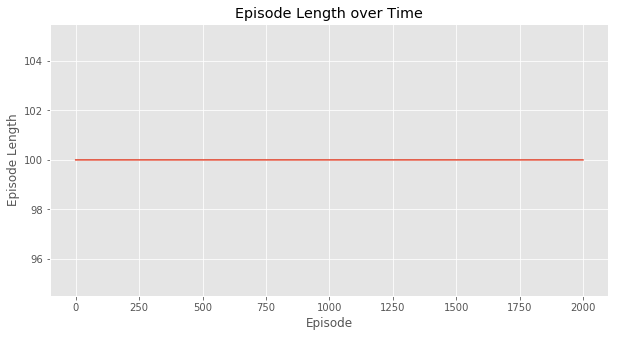

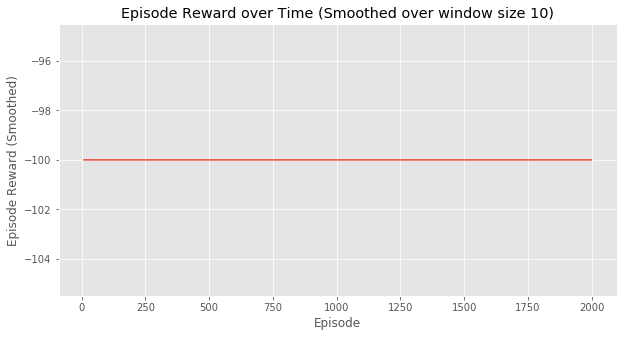

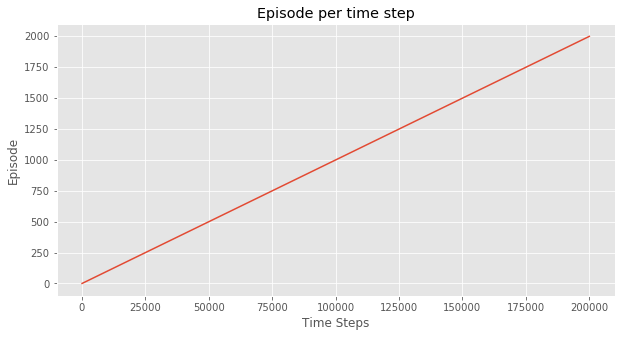

(<matplotlib.figure.Figure at 0x19224198>,
 <matplotlib.figure.Figure at 0xa67e4e0>)

In [24]:
plotting.plot_episode_stats(stats)